# Introduction

This notebook provides examples on to use pre-trained deep neural networks for the object recognition task the notebook. 

Learning objectives:
- Show the difference between detection, and instance segementations
- Show bounding boxes and object detection
- Try Mask-RCNN and observe weaknesses

All images used for testing were downloaded from unplash.com under license [free-usable images](https://unsplash.com/license).

## Table of Content
0. [Libraries](#libraries)
1. [Object Recognition](#object)
2. [COCO Dataset Recognition](#coco)
3. [Faster R-CNN in Pytorch](#frcnn)
4. [Mask R-CNN in Pytorch](#frcnn)
5. [Summary](#summary)

In [1]:
import cv2
import torch
import torchvision

import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import os
import random
from pathlib import Path
import urllib.request
import torchvision.transforms as T

In [2]:
# monkey-patch torchvision to work offline
model_path = Path('../../data/processed/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth').absolute().resolve()
torchvision.models.detection.mask_rcnn.model_urls['maskrcnn_resnet50_fpn_coco']=  'file://{}'.format(model_path)
model_path = Path('../../data/processed/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth').absolute().resolve()
torchvision.models.detection.faster_rcnn.model_urls['fasterrcnn_resnet50_fpn_coco']=  'file://{}'.format(model_path)

# Object Recognition

A more complex problem than the classic image classification problem is the object recognition task. In an image classification we predict the category of an image, however, in object detection not only we classify multiple objects in an image but we can also predict the location of those objects. 

<img src="./segmentation.png" width="800"/>


In this notebook we will discuss **Faster RCNN** model for object recognition and **Mask RCNN** for instance segmentation.

**Object Recognition:**

Objects detected with OpenCV's Deep Neural Network module (dnn) by using a YOLOv3 model trained on **COCO dataset** capable to detect objects of 80 common classes.

<img width=500 heigh=500 src='https://upload.wikimedia.org/wikipedia/commons/3/38/Detected-with-YOLO--Schreibtisch-mit-Objekten.jpg?download'>

Image Credits: [MTheiler](https://en.wikipedia.org/wiki/Object_detection#/media/File:Detected-with-YOLO--Schreibtisch-mit-Objekten.jpg) License: [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)





# Instance Segmentation

In instance segmentation we will combine object recognition and semantic segmentation.

<img width=800 height=500 src='maskrcnn.png'>

Credits: [He et al](https://arxiv.org/pdf/1703.06870.pdf)

# COCO Dataset

[Oficial Website](https://cocodataset.org/#home)

[Progress with time](https://paperswithcode.com/sota/instance-segmentation-on-coco0

COCO is one of the most popular datasets for object detection. Currently, the COCO dataset offers a dataset for object detection, keypoints in faces, and even segmentation. Below, we will be using a list with the category names corresponding to the COCO dataset for object recognition and keypoint.

In [3]:
COCO_INSTANCE_CATEGORY_NAMES = [
    "__background__",
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "N/A",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "N/A",
    "backpack",
    "umbrella",
    "N/A",
    "N/A",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "N/A",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "N/A",
    "dining table",
    "N/A",
    "N/A",
    "toilet",
    "N/A",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "N/A",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
]

COCO_PERSON_KEYPOINT_NAMES = [
    "nose",
    "left_eye",
    "right_eye",
    "left_ear",
    "right_ear",
    "left_shoulder",
    "right_shoulder",
    "left_elbow",
    "right_elbow",
    "left_wrist",
    "right_wrist",
    "left_hip",
    "right_hip",
    "left_knee",
    "right_knee",
    "left_ankle",
    "right_ankle",
]

# Region based CNNs

Region-based convolutional neural networks or regions with CNN features (R-CNNs) are a pioneering approach that applies deep models to object detection. R-CNN models first select several proposed regions from an image and then they use a CNN to perform forward computation to extract features from each proposed area. Afterwards, we use the features of each proposed region to predict their categories and bounding boxes.

Specifically, R-CNNs are composed of four main parts:

- Selective search is performed on the input image to select multiple high-quality proposed regions. These proposed regions are generally selected on multiple scales and have different shapes and sizes. The category and ground-truth bounding box of each proposed region is labeled.

- A pre-trained CNN is selected and placed, in truncated form, before the output layer. It transforms each proposed region into the input dimensions required by the network and uses forward computation to output the features extracted from the proposed regions.

- The features and labeled category of each proposed region are combined as an example to train multiple support vector machines for object classification. Here, each support vector machine is used to determine whether an example belongs to a certain category.

- The features and labeled bounding box of each proposed region are combined as an example to train a linear regression model for ground-truth bounding box prediction.

Although R-CNN models use pre-trained CNNs to effectively extract image features, the main downside is the slow speed. As you can imagine, we can select thousands of proposed regions from a single image, requiring thousands of forward computations from the CNN to perform object detection. This massive computing load means that R-CNNs are not widely used in actual applications.

Source: [R-CNNs](https://d2l.ai/chapter_computer-vision/rcnn.html)

 In this section, we will discuss R-CNNs and a series of improvements made to them: [Fast R-CNN](https://arxiv.org/pdf/1504.08083.pdf), [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf), and [Mask R-CNN](https://arxiv.org/pdf/1703.06870.pdf). We will focus our discussion to the designs of these models and the implementation of the models **Fast R-CNN** and **Mask R-CNN** in Pytorch.

# Fast RCNN

**Fast R-CNN architecture:**
 An input image and multiple regions of interest (RoIs) are input into a fully convolutional network. Each RoI is pooled into a fixed-size feature map and then mapped to a feature vector by fully connected layers (FCs).
The network has two output vectors per RoI: softmax probabilities and per-class bounding-box regression offsets. The architecture is trained end-to-end with a multi-task loss. <br/><br/>

This was the first region based mode for object detection. It has two outputs:

<img width=400 heigh=400 src='fastrcnn.png'/>



Source: [Ross Girshick](https://arxiv.org/pdf/1504.08083.pdf)

# Faster RCNN in Pytorch

Faster RCNN is a popular object detection network that combine Region Proposal Networks (RPN) and Fast RCNN for a faster inference. RPN are 'attention' mechanism that tells the unified network where to look.

<img width=400 heigh=400 src='rpn.png'/>

Source: [Ren et al.](https://arxiv.org/pdf/1506.01497.pdf)

This seperated out the tasks, running bounding box detection first. This was much more accurate.

In the original implementation of Faster RCNN, the backbone used was VGG19. However, Pytorch offers a pretrained version (COCO Dataset) using ResNet50 as the backbone.

In [4]:
FRCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).eval()

Let's try with an example image:

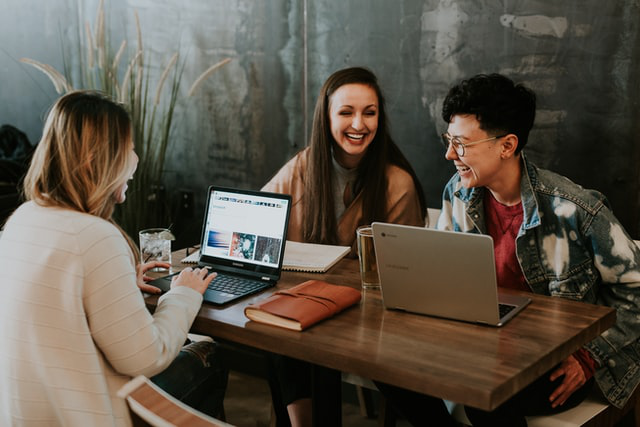

In [5]:
filename = "example.jpg"
Image.open(filename)

Now let's create some functions for the inference. Read the comments in every line:

In [19]:
trans = T.ToTensor()


def get_prediction(img, threshold=0.5):
    """
    Return predictions above a threshold.
    
    You need to understand this right now, we are getting the predictions out as boxes, class names, and scores
    """
    # Prepare image array
    transform = T.Compose([T.ToTensor()])  # Convert PIL Image to tensor
    img = transform(img)  # Apply the transform to the image
    
    
    # Pass the image to the model
    pred = FRCNN([img])  
    pred_class = [
        COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]["labels"].numpy())
    ] # Convert to class
    
    # Bounding boxes
    pred_boxes = [
        [(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]["boxes"].detach().numpy())
    ]  
    
    # Get the Prediction Score
    pred_score = list(pred[0]["scores"].cpu().detach().numpy())
    pred_ts = [pred_score.index(x) for x in pred_score if x > threshold]
    if len(pred_ts)==0:
        return [], [], []
    pred_t = pred_ts[-1]  
    
    # Get list of index with score greater than threshold.
    pred_boxes = pred_boxes[: pred_t + 1]
    pred_class = pred_class[: pred_t + 1]
    return pred_boxes, pred_class, pred_score


def object_detection_api(img_path, threshold=0.5):
    """
    A function that takes in an image, predicts, and shows
    """
    # Open Image
    im = Image.open(img_path).convert("RGB")

    boxes, pred_cls, pred_score = get_prediction(im, threshold)  # Get predictions
    
    # Print predictions
    print(dict(zip(pred_cls, pred_score)))

    # Loop over bounding boxes
    for i in range(len(boxes)):
        # Change color according to prediction score
        color = (0, 255, 0) # green
        if pred_score[i] < 0.4:
            color = (255, 0, 0) # red
        if pred_score[i] > 0.4 and pred_score[i] < 0.7:
            color = (255, 100, 0) # orange

        draw = ImageDraw.Draw(im)
        # Add Rectangle
        draw.rectangle([boxes[i][0], boxes[i][1]], outline=color)
        # Add text
        draw.text(boxes[i][0], pred_cls[i], align="left", fill=color)
    plt.figure(figsize=(10, 10))  # display the output image
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In the `object_detecion_api` we created some logic to change the color of the bounding boxes according to the confidence in the prediction. We can also pass the parameter `threshold` which will filter the results below the threshold.

{'laptop': 0.9962903, 'person': 0.06968314, 'cup': 0.054931343, 'book': 0.19748788, 'dining table': 0.06412586, 'keyboard': 0.11180263, 'handbag': 0.053203776, 'chair': 0.15408868, 'wine glass': 0.2469902, 'cell phone': 0.07793535, 'potted plant': 0.082282536, 'backpack': 0.06588374, 'couch': 0.059280585, 'tie': 0.05559941}


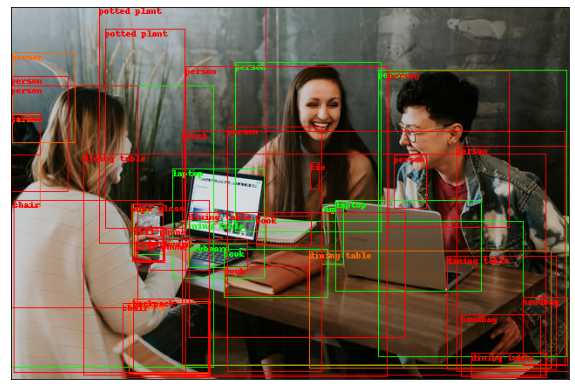

In [20]:
# If we set the threshold to zero it will show all results
object_detection_api(filename, threshold=0)

{'laptop': 0.9962903, 'person': 0.5345933, 'cup': 0.92141986, 'book': 0.9191225, 'dining table': 0.8974145, 'keyboard': 0.78374165}


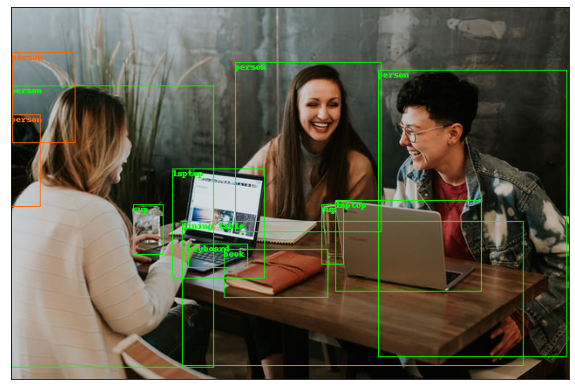

In [21]:
# Let's filter the results for those prediction with confidence lower than 0.5
object_detection_api(filename, threshold=0.5)

{'laptop': 0.9962903, 'person': 0.99442214, 'cup': 0.92141986, 'book': 0.9191225}


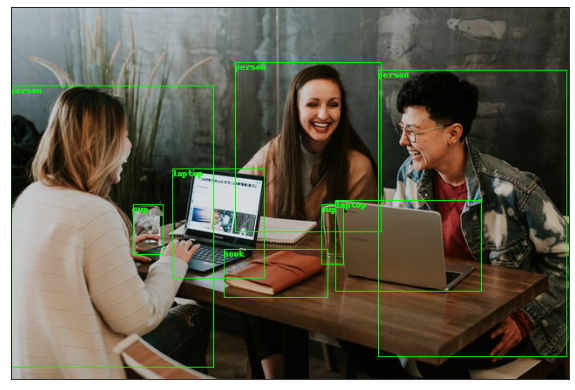

In [22]:
# We could also take only those predictions above 0.9 (Strong confidence)
object_detection_api(filename, threshold=0.9)

<div class="alert alert-success" style="font-size:100%">

**Exercise 1:** <br>
    
1. Use the code below to get the file names of the images in the example folder.
    
```python
import os
images = os.listdir('./exercise1')
```
    
2. Loop through the images with a threshold=0.5

</div>



You can click in the button below the reveal the solution for exercise 1.

<details>    
<summary>
    <font size="4" color="darkblue"><b>See the solution for Exercise 1</b></font>
</summary>
    
```python
import os
DIR = './exercise1'
images = os.listdir(DIR)

for image in images:
    object_detection_api(f'{DIR}/{image}', threshold=0.5)
```

</details>

# Mask RCNN in Pytorch

If training data is labeled with the pixel-level positions of each object in an image, a Mask R-CNN model can effectively use these detailed labels to further improve the precision of object detection.

Mask R-CNN is a modification to the Faster R-CNN model. Mask R-CNN models replace the RoI pooling layer with an RoI alignment layer. This allows the use of bilinear interpolation to retain spatial information on feature maps, making Mask R-CNN better suited for pixel-level predictions. The RoI alignment layer outputs feature maps of the same shape for all RoIs. This not only predicts the categories and bounding boxes of RoIs, but allows us to use an additional fully convolutional network to predict the pixel-level positions of objects. We will describe how to use fully convolutional networks to predict pixel-level semantics in images later in this chapter.

Find the regions first. Extract the regions. Then do the classifications

Source: [R-CNN](https://d2l.ai/chapter_computer-vision/rcnn.html)

Architecture:
<img height=600 width=600 src='mask_arch.png'/>

Source: [He et al.](https://arxiv.org/pdf/1703.06870.pdf)

In [23]:
MRCNN = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()

In [37]:
def get_prediction_mask(img_path, threshold):
    transform = T.Compose([T.ToTensor()])
    img = transform(Image.open(img_path))
    pred = MRCNN([img])
    pred_score = list(pred[0]["scores"].detach().numpy())
    pred_ts = [pred_score.index(x) for x in pred_score if x > threshold]
    if len(pred_ts)==0:
        return [], [], []
    pred_t = pred_ts[-1]
    masks = (pred[0]["masks"] > 0.5).squeeze().detach().cpu().numpy()
    pred_class = [
        COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]["labels"].numpy())
    ]
    pred_boxes = [
        [(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]["boxes"].detach().numpy())
    ]
    masks = masks[: pred_t + 1]
    pred_boxes = pred_boxes[: pred_t + 1]
    pred_class = pred_class[: pred_t + 1]
    return masks, pred_boxes, pred_class, pred_score


def random_colour_masks(image):
    colors = [
        [0, 255, 0],
        [0, 0, 255],
        [255, 0, 0],
        [0, 255, 255],
        [255, 255, 0],
        [255, 0, 255],
        [80, 70, 180],
        [250, 80, 190],
        [245, 145, 50],
        [70, 150, 250],
        [50, 190, 190],
    ]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colors[random.randrange(0, 10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask


def instance_segmentation_api(img_path, threshold=0.5, rect_th=1, text_size=1):
    masks, boxes, pred_cls, pred_score = get_prediction_mask(img_path, threshold)
    print(dict(zip(pred_cls, pred_score)))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = random_colour_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(
            img, boxes[i][0], boxes[i][1], color=(0, 255, 0), thickness=rect_th
        )
        # Resize font according to image size
        scale = 1  # this value can be from 0 to 1 (0,1] to change the size of the text relative to the image
        imageHeight, imageWidth, _ = img.shape
        fontScale = min(imageWidth, imageHeight) / (25 / scale)
        cv2.putText(
            img,
            f'{pred_cls[i]}_{pred_score[i]:2.2f}',
            boxes[i][0],
            cv2.FONT_HERSHEY_SIMPLEX,
            text_size,
            (0, 255, 0),
        )
    plt.figure(figsize=(20, 30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
instance_segmentation_api('./exercise2/mask1.jpg'.format(), threshold=0.5)

{'person': 0.9105501, 'chair': 0.5785099, 'bottle': 0.76460415, 'cup': 0.51194525}


<div class="alert alert-success" style="font-size:100%">

**Exercise 2:** <br>
    
1. Repeat the steps for Exercise 1 using images in `./exercise1` and `./exercise2` this time the Mask R-CNN model.
2. In addition, modify the function `instance_segmentation_api` so it will be optional to get the semantic segmentation, the bouding boxes with prediction class or both (instance segmentation).
</div>



You can click in the button below the reveal the solution for exercise 2

<details>    
<summary>
    <font size="4" color="darkblue"><b>Hints for Exercise 2</b></font>
</summary>
    
1. There are many ways of getting the paths using python. We will use an advanced function using python functional programming paradign like: `lambda`, `map`.
    
```python
get_list_images = lambda path: list(map(lambda x,y: f'{y}/{x}', os.listdir(path), [path]*len(os.listdir(path))))
flatten = lambda l: [item for sublist in l for item in sublist]
combine_lists = lambda paths: flatten(list(map(get_list_images, paths)))
combine_lists(['./exercise1', './exercise2'])
    
```
2. You can always pass some boolean variables and create some conditional inside your function.
```python
    instance_segmentation_api(img_path, threshold=0.5, rect_th=1, text_size=1, segmantic_segmentation=False, bounding_boxes=False, both=True)
```

</details>

<div class="alert alert-success" style="font-size:100%">

**Exercise 3:** <br>
    
Download you own image to try and break Mask-RCNN. This way you can find the limits of this pre-trained model
    
- Find an image
- Upload it to the notebook folder using jupyter
- pass the image path into instance_segmentation_api 
</div>



# Summary

Source: [RCNN](https://d2l.ai/chapter_computer-vision/rcnn.html)

- An R-CNN model selects several proposed regions and uses a CNN to perform forward computation and extract the features from each proposed region. It then uses these features to predict the categories and bounding boxes of proposed regions.

- Fast R-CNN improves on the R-CNN by only performing CNN forward computation on the image as a whole. It introduces an RoI pooling layer to extract features of the same shape from RoIs of different shapes.

- Faster R-CNN replaces the selective search used in Fast R-CNN with a region proposal network. This reduces the number of proposed regions generated, while ensuring precise object detection.

- Mask R-CNN uses the same basic structure as Faster R-CNN, but adds a fully convolution layer to help locate objects at the pixel level and further improve the precision of object detection.

# Auto:test

In [32]:
# import os
# DIR = './exercise1'
# images = os.listdir(DIR)

# for image in images:
#     object_detection_api(f'{DIR}/{image}', threshold=0.5)

In [30]:
# import os
# DIR = './exercise1'
# images = os.listdir(DIR)

# for image in images:
#     instance_segmentation_api(f'{DIR}/{image}', threshold=0.5)

In [31]:
# import os
# DIR = './exercise2'
# images = os.listdir(DIR)

# for image in images:
#     instance_segmentation_api(f'{DIR}/{image}', threshold=0.5)